In [2]:
import pandas as pd
import numpy as np

## Load the dataset

In [5]:
"""
Converting units from NGSIM dataset to international units
Converted length units to meters and time units to 0.1 seconds
 """
def unitConversion(df):
    ft_to_m = 0.3048
    for strs in ["Local_X", "Local_Y", "v_Vel", "v_Acc", "Space_Headway"]:
        df[strs] = df[strs] * ft_to_m
    df["Global_Time"] = df["Global_Time"] / 100
    return df

In [7]:
df = pd.read_csv(r"us-101.csv")
df = df.drop_duplicates(subset=df.columns, keep="first")
df = df[df["v_Class"] != 1]
df = df[["Vehicle_ID", "Global_Time","Local_X", "Local_Y","v_Class","v_Vel", "v_Acc", "Lane_ID", "Preceding", "Following", "Space_Headway", "Location"]]
df = unitConversion(df)

## Preprocessing the data

### Labeling, processing time, finding surrounding vehicle data

Label each sample: 0: follow the chute, 1: change lane to the left; 2: change lane to the right

In [11]:
"""确定样本标签"""
df0 = df.sort_values(by=["Vehicle_ID","Global_Time"], ascending=[True, True])
df0["LC"] = df0["Lane_ID"].diff(periods=-1)
df0["LC_sj"] = df0["Lane_ID"].diff(periods=-30) # 换道时间阈值
df0["sjc"] = df0["Global_Time"].diff(periods=-1)
df0 = df0[(df0["sjc"] == -1)]   # 原数据分成三个部分
# 向右换道
df2 = df0[(df0["LC"] == -1)&(df0["LC_sj"] == -1)][["Vehicle_ID", "Global_Time", "Lane_ID","v_Class"]]
df2 = df2[(df2["Lane_ID"]!=6)]  # 删除强制换道
# 向左换道
df1 = df0[(df0["LC"] == 1)&(df0["LC_sj"] == 1)][["Vehicle_ID", "Global_Time", "Lane_ID","v_Class"]]
df1 = df1[(df1["Lane_ID"]!=7) & (df1["Lane_ID"]!=8)]  # 删除强制换道
df1 = df1.head(df2.shape[0])
# 跟驰
df0 = df0[~(df0["Vehicle_ID"].isin(df1["Vehicle_ID"]))]
df0 = df0[~(df0["Vehicle_ID"].isin(df2["Vehicle_ID"]))]
df0 = df0[(df0["LC"] == 0)&(df0["Space_Headway"] != 0)]
df0 = df0.sort_values(by=["Vehicle_ID", "Space_Headway"], ascending=[True, True])
df0 = df0.drop_duplicates(subset=["Vehicle_ID"], keep="first")[["Vehicle_ID", "Global_Time" , "Lane_ID","v_Class"]]
df0 = df0[(df0["Lane_ID"]!=1) & (df0["Lane_ID"]!=6) & (df0["Lane_ID"]!=7) & (df0["Lane_ID"]!=8)]
df0 = df0.head(df2.shape[0])
# 打标签
df0["label"] = 0
df1["label"] = 1
df2["label"] = 2

In [12]:
# 研究时间(deal with time)
res0 = pd.concat([df2, df1, df0], ignore_index=True)
res0 = res0.reset_index(drop=False)
res1 = pd.DataFrame(np.repeat(res0.values,80,axis=0)) # 换道点前（80+T）/10秒
res1.columns = res0.columns
res1["Global_Time"] -= res1.groupby("index").cumcount()
res1["Change_Time"] = 0-res1.groupby("index").cumcount()
res=res1
res = res.sort_values(by=["Vehicle_ID", "Global_Time"], ascending=[True, True]) #升序排列
res = pd.merge(res, df, how="left", on=["Vehicle_ID","Global_Time"])

Find the surrounding vehicles of the target vehicle: the preceding vehicle and following vehicle in the current lane, the preceding vehicle, adjacent vehicle, and following vehicle in the left lane, as well as the preceding vehicle, adjacent vehicle, and following vehicle in the right lane. Additionally, retrieve all data for these vehicles at the same time.

In [14]:
"""确定周围车辆"""
# 当前车道
res = pd.merge(res, df, how="left", left_on=["Preceding", "Global_Time"], right_on=["Vehicle_ID", "Global_Time"], suffixes=("", "_01"))
res = pd.merge(res, df, how="left", left_on=["Following", "Global_Time"], right_on=["Vehicle_ID", "Global_Time"], suffixes=("", "_02"))
# 左侧车道
res["Lane_Left"] =  res["Lane_ID"] - 1

res11 = pd.merge(res, df, how="left", left_on=["Lane_Left", "Global_Time"], right_on=["Lane_ID", "Global_Time"], suffixes=("", "_11"))
res11["Local_Y_diff_11"] = res11["Local_Y_11"] - res11["Local_Y"]
res11 = res11.sort_values(by=["Vehicle_ID", "Local_Y_diff_11"], ascending=[True, True])
res11 = res11[res11["Local_Y_diff_11"] > 0]
res11 = res11.drop_duplicates(subset=["Vehicle_ID", "Global_Time"], keep="first") 
res = pd.merge(res, res11, how="left", on=res.columns.tolist())

res12 = pd.merge(res, df, how="left", left_on=["Lane_Left", "Global_Time"], right_on=["Lane_ID", "Global_Time"], suffixes=("", "_12"))
res12["Local_Y_diff_12"] = res12["Local_Y_12"] - res12["Local_Y"]
res12 = res12.sort_values(by=["Vehicle_ID", "Local_Y_diff_12"], ascending=[True, True])
res12 = res12[res12["Local_Y_diff_12"] <= 0]
res12 = res12.drop_duplicates(subset=["Vehicle_ID", "Global_Time"], keep="last")
res = pd.merge(res, res12, how="left", on=res.columns.tolist())

# 右侧车道
res["Lane_Right"] =  res["Lane_ID"] + 1

res21 = pd.merge(res, df, how="left", left_on=["Lane_Right", "Global_Time"], right_on=["Lane_ID", "Global_Time"], suffixes=("", "_21"))
res21["Local_Y_diff_21"] = res21["Local_Y_21"] - res21["Local_Y"]
res21 = res21.sort_values(by=["Vehicle_ID", "Local_Y_diff_21"], ascending=[True, True])
res21 = res21[res21["Local_Y_diff_21"] > 0]
res21 = res21.drop_duplicates(subset=["Vehicle_ID", "Global_Time"], keep="first") 
res = pd.merge(res, res21, how="left", on=res.columns.tolist())

res22 = pd.merge(res, df, how="left", left_on=["Lane_Right", "Global_Time"], right_on=["Lane_ID", "Global_Time"], suffixes=("", "_22"))
res22["Local_Y_diff_22"] = res22["Local_Y_22"] - res22["Local_Y"]
res22 = res22.sort_values(by=["Vehicle_ID", "Local_Y_diff_22"], ascending=[True, True])
res22 = res22[res22["Local_Y_diff_22"] <= 0]
res22 = res22.drop_duplicates(subset=["Vehicle_ID", "Global_Time"], keep="last")
res = pd.merge(res, res22, how="left", on=res.columns.tolist())

In [15]:
res=res[res["v_Class_x"] == 2]#主要研究小型车(mainly focus on small cars)

### Setting the sliding time window，taking 1500 data for each category

In [17]:
from random import sample

In [18]:
t=40 #滑动时窗长度为4s
# 滑动时窗
result0 = res[(res["label"] == 0) & (res["Change_Time"] >= -t) & (res["Change_Time"] <= 0)]
result0 = result0.sample(n=1500)
result1 = res[(res["label"] == 1) & (res["Change_Time"] >= -t) & (res["Change_Time"] <= 0)]
result1 = result1.sample(n=1500)
result2 = res[(res["label"] == 2) & (res["Change_Time"] >= -t) & (res["Change_Time"] <= 0)]
result2 = result2.sample(n=1500)
result = pd.concat([result2, result1, result0], ignore_index=True)
result

,index,Vehicle_ID,Global_Time,Lane_ID_x,v_Class_x,label,Change_Time,Local_X,Local_Y,v_Class_y,...,Local_Y_22,v_Class_22,v_Vel_22,v_Acc_22,Lane_ID_22,Preceding_22,Following_22,Space_Headway_22,Location_22,Local_Y_diff_22
0,161.0,726.0,1.118847e+10,5.0,2.0,2.0,-24,17.063618,227.606657,2.0,...,198.211745,2.0,12.192000,0.000000,6.0,724.0,0.0,31.089600,us-101,-29.394912
1,138.0,631.0,1.118849e+10,5.0,2.0,2.0,-35,16.797528,190.499390,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,224.0,1018.0,1.118848e+10,5.0,2.0,2.0,-14,15.864230,302.365562,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,425.0,2408.0,1.118848e+10,3.0,2.0,2.0,-30,9.122664,267.547039,2.0,...,210.619238,3.0,13.206984,-2.511552,4.0,2402.0,2442.0,109.316520,us-101,-56.927801
4,107.0,483.0,1.118848e+10,2.0,2.0,2.0,-37,6.226150,195.521275,2.0,...,175.410876,2.0,11.890248,2.282952,3.0,479.0,495.0,29.858208,us-101,-20.110399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1157.0,511.0,1.118848e+10,2.0,2.0,0.0,-40,5.799125,601.288104,2.0,...,601.089070,2.0,5.699760,3.413760,3.0,486.0,500.0,35.853624,us-101,-0.199034
4496,1208.0,646.0,1.118849e+10,2.0,2.0,0.0,-35,5.984138,415.641434,2.0,...,406.969570,2.0,9.128760,-0.268224,3.0,644.0,653.0,26.947368,us-101,-8.671865
4497,1161.0,528.0,1.118848e+10,4.0,2.0,0.0,-6,12.479426,585.907591,2.0,...,566.608570,2.0,4.572000,0.000000,5.0,544.0,545.0,26.093928,us-101,-19.299022
4498,1236.0,715.0,1.118848e+10,2.0,2.0,0.0,-28,5.232197,78.527453,2.0,...,63.302693,2.0,3.569208,-0.271272,3.0,694.0,708.0,18.114264,us-101,-15.224760


In [19]:
res = res.drop_duplicates(subset=['Vehicle_ID', 'Change_Time']).reset_index(drop=True)#去掉重复的

Find all the data in the first 4s from 'res' for each piece of data in the 'result'.

In [21]:
#以result里每条数据从res里寻找前4s的所有数据
re=pd.DataFrame(columns=res.columns)
for i in range(len(result)):
    temp=result.iloc[i:i+1,]
    change_time=temp['Change_Time']
    v_id=temp['Vehicle_ID']
    idx=temp['index']
    temp0=res[(res['Vehicle_ID']==int(v_id))  & (res['index']==int(idx))]
    temp1=temp0[(temp0['Change_Time']<=int(change_time)) & (temp0['Change_Time']>int(change_time)-t)]
    #print(f"Iteration {i}: Found {len(temp0)} rows")
    re = pd.concat([re, temp1], ignore_index=True)

/var/folders/sd/5dzb2nqn70gfb6qxkzxqzbxc0000gn/T/ipykernel_13154/185186781.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  temp0=res[(res['Vehicle_ID']==int(v_id))  & (res['index']==int(idx))]
/var/folders/sd/5dzb2nqn70gfb6qxkzxqzbxc0000gn/T/ipykernel_13154/185186781.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  temp1=temp0[(temp0['Change_Time']<=int(change_time)) & (temp0['Change_Time']>int(change_time)-t)]
/var/folders/sd/5dzb2nqn70gfb6qxkzxqzbxc0000gn/T/ipykernel_13154/185186781.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  re = pd.co

In [22]:
res=re.copy()

### Filling of vacancy values

In [24]:
resb=res.copy()#将空缺的v，a换成本车的，车头间距换成9999
resb['Space_Headway'].replace(0,9999,inplace=True)
nums=['01','02','11','12','21','22']#nums表示01,02。。。表示车辆六个位置的车
#对1,6车道进行研究
resb[resb['Lane_ID_x']==1]['Local_Y_diff_11'].fillna(value=0,inplace=True)
resb[resb['Lane_ID_x']==1]['Local_Y_diff_12'].fillna(value=0,inplace=True)
resb[resb['Lane_ID_x']==6]['Local_Y_diff_21'].fillna(value=0,inplace=True)
resb[resb['Lane_ID_x']==6]['Local_Y_diff_22'].fillna(value=0,inplace=True)
resb['Space_Headway_02']=-resb['Space_Headway_02']
for i in nums:
    resb['v_Vel_'+i].fillna(value=resb['v_Vel'],inplace=True)
    resb['v_Acc_'+i].fillna(value=resb['v_Acc'],inplace=True)
nums2=['11','21']
for i in nums2:
    resb['Local_Y_diff_'+i].fillna(value=9999,inplace=True)
nums3=['12','22']
for i in nums3:
    resb['Local_Y_diff_'+i].fillna(value=-9999,inplace=True)

/var/folders/sd/5dzb2nqn70gfb6qxkzxqzbxc0000gn/T/ipykernel_13154/1472750530.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  resb['Space_Headway'].replace(0,9999,inplace=True)
/var/folders/sd/5dzb2nqn70gfb6qxkzxqzbxc0000gn/T/ipykernel_13154/1472750530.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resb[resb['Lane_ID_x']==1]['Local_Y_di

### Extracting and filtering input features

In [26]:
resb=resb[['Change_Time','Vehicle_ID','v_Class_x','label','v_Vel','v_Acc','Space_Headway','v_Class','v_Vel_01','v_Acc_01','v_Class_02','v_Vel_02','v_Acc_02','Space_Headway_02','v_Class_11','v_Vel_11','v_Acc_11','Local_Y_diff_11','v_Class_12','v_Vel_12','v_Acc_12','Local_Y_diff_12','v_Class_21','v_Vel_21','v_Acc_21','Local_Y_diff_21','v_Class_22','v_Vel_22','v_Acc_22','Local_Y_diff_22']]
res=resb

Adding weights and eigenvalues to large vehicles

In [28]:
res['v_Class'].fillna(value=10,inplace=True)#将空缺的车的型号标为10
nums1=['02','11','12','21','22']#去掉01，因为前车是v_Class
for i in nums1:
    res['v_Class_'+i].fillna(value=10,inplace=True)
res = pd.concat([res, pd.DataFrame(columns=['v_Class_att','v_Class_att_01','v_Class_att_02','v_Class_att_11','v_Class_att_12','v_Class_att_21','v_Class_att_22'])], sort=False)
res['v_Class_att'].fillna(value=0,inplace=True)
res['v_Class_att_01'].fillna(value=0,inplace=True)
res['v_Class_att_02'].fillna(value=0,inplace=True)
res['v_Class_att_11'].fillna(value=0,inplace=True)
res['v_Class_att_12'].fillna(value=0,inplace=True)
res['v_Class_att_21'].fillna(value=0,inplace=True)
res['v_Class_att_22'].fillna(value=0,inplace=True)#这里是对车辆类型进行一个加权，对于大车赋值1，其余赋值0
res.loc[res['v_Class']==3,'v_Class_att_01']=1
for i in nums1:
    res.loc[res['v_Class_'+i]==3,'v_Class_att_'+i]=1
res

/var/folders/sd/5dzb2nqn70gfb6qxkzxqzbxc0000gn/T/ipykernel_13154/505405285.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  res['v_Class'].fillna(value=10,inplace=True)#将空缺的车的型号标为10
/var/folders/sd/5dzb2nqn70gfb6qxkzxqzbxc0000gn/T/ipykernel_13154/505405285.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

,Change_Time,Vehicle_ID,v_Class_x,label,v_Vel,v_Acc,Space_Headway,v_Class,v_Vel_01,v_Acc_01,...,v_Vel_22,v_Acc_22,Local_Y_diff_22,v_Class_att,v_Class_att_01,v_Class_att_02,v_Class_att_11,v_Class_att_12,v_Class_att_21,v_Class_att_22
0,-63,726.0,2.0,2.0,8.726424,-3.261360,18.431256,2.0,10.671048,2.959608,...,8.726424,-3.261360,-9999.000000,0,0,0,0,0,0,0
1,-62,726.0,2.0,2.0,8.382000,-3.413760,18.653760,2.0,10.984992,3.346704,...,8.382000,-3.413760,-9999.000000,0,0,0,0,0,0,0
2,-61,726.0,2.0,2.0,8.037576,-3.261360,18.949416,2.0,11.320272,3.413760,...,8.037576,-3.261360,-9999.000000,0,0,0,0,0,0,0
3,-60,726.0,2.0,2.0,7.781544,-1.914144,19.321272,2.0,11.634216,2.941320,...,7.781544,-1.914144,-9999.000000,0,0,0,0,0,0,0
4,-59,726.0,2.0,2.0,7.650480,-0.630936,19.747992,2.0,11.865864,1.853184,...,7.650480,-0.630936,-9999.000000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141395,-31,773.0,2.0,0.0,7.924800,-1.453896,15.230856,2.0,7.309104,-2.048256,...,9.131808,0.100584,-0.928421,0,0,0,0,0,0,0
141396,-30,773.0,2.0,0.0,7.796784,-1.405128,15.154656,2.0,7.202424,-0.207264,...,9.144000,0.146304,-0.800405,0,0,0,0,0,0,0
141397,-29,773.0,2.0,0.0,7.741920,0.027432,15.099792,2.0,7.239000,1.219200,...,9.159240,0.167640,-0.649529,0,0,0,0,0,0,0
141398,-28,773.0,2.0,0.0,7.833360,1.911096,15.066264,2.0,7.348728,1.286256,...,9.174480,0.143256,-0.494386,0,0,0,0,0,0,0


Handling of duplicate data

In [30]:
data = res.values  # 将 DataFrame转为 NumPy数组
# 非重叠窗口的起始索引
num_windows = len(data) // t
window_indices = np.arange(0, num_windows * t).reshape(-1, t)

# 提取非重叠窗口数据
windows = data[window_indices]
flattened_windows = windows.reshape(num_windows, -1)
columns = []
for j in range(t):
    columns.extend([f"{col}_{j}" for col in res.columns])
newres = pd.DataFrame(flattened_windows, columns=columns)

In [31]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',10)
newres.dropna(axis=0,how='any',inplace=True)
newres

Change_Time_0 Vehicle_ID_0 v_Class_x_0 label_0    v_Vel_0   v_Acc_0  \
0              -63        726.0         2.0     2.0   8.726424  -3.26136   
1              -74        631.0         2.0     2.0  12.960096   3.41376   
2              -53       1018.0         2.0     2.0   9.009888  0.545592   
3              -69       2408.0         2.0     2.0     10.668       0.0   
4              -76        483.0         2.0     2.0   8.308848       0.0   
...            ...          ...         ...     ...        ...       ...   
3530           -79        511.0         2.0     0.0   0.048768 -0.539496   
3531           -74        646.0         2.0     0.0  10.579608 -0.826008   
3532           -45        528.0         2.0     0.0   0.865632  0.185928   
3533           -67        715.0         2.0     0.0   4.102608 -0.042672   
3534           -66        773.0         2.0     0.0    9.02208 -1.094232   

     Space_Headway_0 v_Class_0 v_Vel_01_0 v_Acc_01_0 v_Class_02_0 v_Vel_02_0  \
0          18.431256       2.0  10.671048   2.959608          2.0   9.610344   
1          31.245048       2.0  14.846808        0.0          2.0  11.682984   
2          15.861792       2.0  10.914888   1.591056          2.0   9.153144   
3          14.877288       2.0  11.439144   0.173736          2.0  11.564112   
4          24.472392       2.0  10.768584    1.31064          2.0      6.096   
...              ...       ...        ...        ...          ...        ...   
3530        6.425184       2.0   0.954024        0.0          2.0    2.62128   
3531       22.591776       2.0    7.98576  -3.115056          2.0     12.192   
3532       10.052304       2.0    0.39624  -0.905256          2.0        0.0   
3533       14.389608       2.0     6.6294        0.0          2.0     3.5052   
3534       18.327624       2.0   8.071104   0.024384          2.0   11.84148   

     v_Acc_02_0 Space_Headway_02_0 v_Class_11_0 v_Vel_11_0 v_Acc_11_0  \
0        0.0762         -50.310288          2.0      15.24        0.0   
1      0.432816         -48.262032          2.0   9.607296        0.0   
2     -0.018288         -16.919448          2.0  13.691616  -0.249936   
3     -1.274064         -15.236952          2.0  10.689336  -0.024384   
4           0.0         -26.191464          2.0     7.0866   -0.01524   
...         ...                ...          ...        ...        ...   
3530   -3.41376         -13.331952          2.0   2.648712    -2.4384   
3531        0.0         -35.679888          2.0   3.678936        0.0   
3532        0.0          -6.428232          2.0   5.428488        0.0   
3533  -0.036576         -10.625328          2.0   4.532376   0.316992   
3534        0.0         -36.341304          2.0    9.17448   0.402336   

     Local_Y_diff_11_0 v_Class_12_0 v_Vel_12_0 v_Acc_12_0 Local_Y_diff_12_0  \
0            14.461236          2.0  13.712952   0.021336        -13.315798   
1            23.445521          2.0   9.622536   1.182624        -10.608869   
2             3.128772          2.0     12.192        0.0        -22.273565   
3            11.439754          2.0  12.030456     -1.905         -8.704783   
4              0.16002          2.0   4.565904  -0.073152         -26.09789   
...                ...          ...        ...        ...               ...   
3530          1.800758          2.0   2.785872        0.0          -9.76183   
3531          3.396386          2.0    8.73252  -3.182112         -23.95027   
3532         18.721121          2.0   4.581144  -0.027432         -7.058558   
3533          8.730386          2.0   4.550664  -0.496824         -8.186623   
3534          1.923593          2.0    9.09828      0.381        -20.698358   

     v_Class_21_0 v_Vel_21_0 v_Acc_21_0 Local_Y_diff_21_0 v_Class_22_0  \
0             2.0     12.192        0.0          0.946404         10.0   
1             2.0  17.553432   3.358896        105.054502         10.0   
2             2.0  12.307824     1.2954         18.275808          2.0   
3        

Extract the columns of the feature input

In [33]:
ss=[",".join(newres.columns)]
list1=ss[0].split(",")
for k0 in list1:
    if k0=='Vehicle_ID':
        m0=list1.index(k0)
        del list1[m0]
    else:
        continue
for k1 in list1:
    for g in range(100):
        if k1=='Change_Time_'+str(g):
            m1=list1.index(k1)
            del list1[m1]
for k2 in list1:
    for g2 in range(100):
        if k2=='label_'+str(g2):
            m2=list1.index(k2)
            del list1[m2]
for i in range(t):
    k5='Vehicle_ID_'+str(i)
    m5=list1.index(k5)
    del list1[m5]
for i in nums1:
    for j in range(t):
        k3='v_Class_'+i+'_'+str(j)
        m3=list1.index(k3)
        del list1[m3]
for i in range(t):
    k4='v_Class_'+str(i)
    m4=list1.index(k4)
    del list1[m4]
#list1是特征输入的columns

## model building

In [38]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [53]:
newres03=newres.copy()
X=newres03.copy()
Y=newres03[['label_0']]

In [55]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, train_size=0.8, random_state=40)
x1_train=X1_train[list1]
x1_test= X1_test[list1]

In [57]:
x_train=x1_train.values
x_test=x1_test.values
Y_train=Y1_train.values
Y_test=Y1_test.values

In [59]:
label_counts = Y1_train['label_0'].value_counts()
label_counts

label_0
0.0    1053
2.0     890
1.0     453
Name: count, dtype: int64

In [61]:
#归一化
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)
#Y=scaler.fit_transform(Y)

In [63]:
y_train = to_categorical(Y_train, 3)
y_test = to_categorical(Y_test, 3)#onehot

In [65]:
train3DX=x_train.reshape([-1,40,28])#换成三维28
test3DX=x_test.reshape([-1,40,28])#28

In [67]:
print(train3DX.shape)  # 应为 (样本数, 时间步长, 特征数)
print(test3DX.shape)

(2396, 40, 28)
(600, 40, 28)


In [69]:
print(y_train.shape) 
print(y_test.shape) 

(2396, 3)
(600, 3)


In [71]:
from keras import Input, Model
from keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [73]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [89]:
input_shape = (train3DX.shape[1], train3DX.shape[2])
n_classes = 3

model = build_model(
    input_shape=input_shape,
    head_size=64,  # 注意力头维度
    num_heads=4,  # 注意力头数
    ff_dim=128,  # 前馈网络隐藏层维度
    num_transformer_blocks=4,  # Transformer 块数量
    mlp_units=[28, 64],  # 分类头全连接层的单元数
    mlp_dropout=0.2,  # 分类头的 Dropout
    dropout=0.5,  # Transformer Dropout
)

# 编译模型
model.compile(
    loss="categorical_crossentropy",  # 因为标签是独热编码
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"], 
)

# 打印模型结构
model.summary()

# 设置训练回调
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

# 训练模型
history = model.fit(
    train3DX,
    y_train,
    validation_split=0.2, 
    epochs=100,
    batch_size=40,
    callbacks=callbacks,
)

test_loss, test_accuracy = model.evaluate(test3DX, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 40, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 28)    │     29,468 │ input_layer_3[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 40, 28)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 28)    │         56 │ dropout_43[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 40, 28)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 40, 128)   │      3,712 │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 40, 128)   │          0 │ conv1d_24[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 40, 28)    │      3,612 │ dropout_44[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 28)    │         56 │ conv1d_25[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 40, 28)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 28)    │     29,468 │ add_25[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 40, 28)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 28)    │         56 │ dropout_46[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 40, 28)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 40, 128)   │      3,712 │ add_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 40, 128)   │          0 │ conv1d_26[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 40, 28)    │      3,612 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 28)    │         56 │ conv1d_27[0][0]   │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 150,479 (587.81 KB)

 Trainable params: 150,479 (587.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4401 - loss: 1.1236 - val_accuracy: 0.6083 - val_loss: 0.9011
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6521 - loss: 0.7849 - val_accuracy: 0.7229 - val_loss: 0.8031
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6979 - loss: 0.6755 - val_accuracy: 0.7979 - val_loss: 0.6099
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7421 - loss: 0.5773 - val_accuracy: 0.8000 - val_loss: 0.5733
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7651 - loss: 0.5489 - val_accuracy: 0.8042 - val_loss: 0.5041
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7804 - loss: 0.5253 - val_accuracy: 0.8146 - val_loss: 0.4743
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7758 - loss: 0.5195 - val_accuracy: 0.8000 - val_loss: 0.4925
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7784 - loss: 0.5121 - val_accuracy: 0.

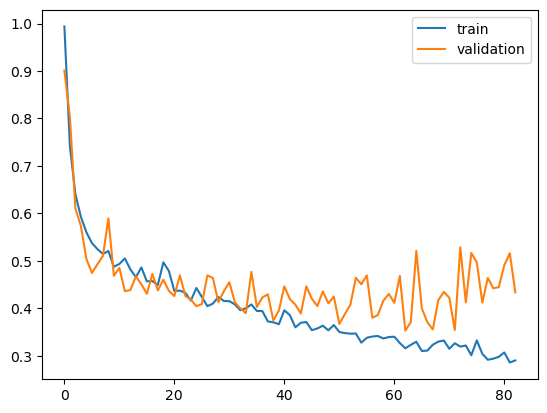

In [91]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.savefig("loss.png", dpi=300)
pyplot.show()

Calculate the confusion matrix

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


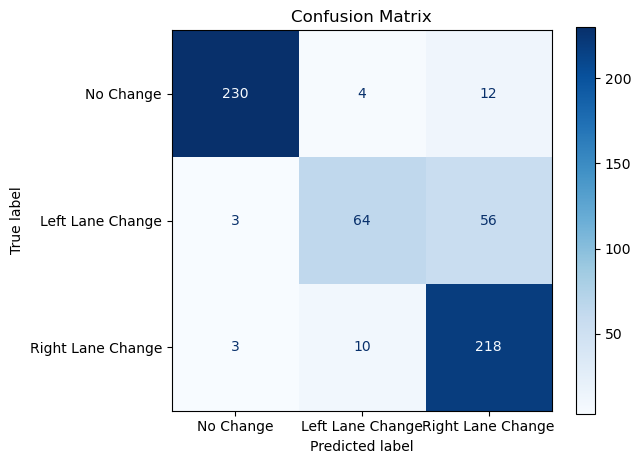

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 使用模型预测测试集标签
y_pred = model.predict(test3DX)

# 将预测结果从独热编码转换为类别标签
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 计算混淆矩阵
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Change", "Left Lane Change", "Right Lane Change"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

## Saving models and results

In [97]:
model.save("lane_change_intent_model.h5")

In [99]:
import pickle
import json

with open("training_history.pkl", "wb") as file:
    pickle.dump(history.history, file)
    
test_results = {"loss": test_loss, "accuracy": test_accuracy}
with open("test_results.json", "w") as file:
    json.dump(test_results, file)